# This tutorial shows how to run PyIRI for a long duration really fast
PyIRI can calculate time series of the ionospheric parameters for the 
user provided array of F10.7. In this configuration PyIRI can be run for
up to 1 year. The estimation of the parameters occurs simultaneously at
all grid points and for all desired diurnal time frames. The parameters
are obtained by linearly interpolating between min and max levels of solar
activity, and by interpolation between median monthly values to the day of
interest.


/var/folders/hx/vfmrc7fn3cb_5y7fpsjwylcw0000gq/T/ipykernel_68670/2324084096.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  F107_cleaned = F107[ind_good]
/var/folders/hx/vfmrc7fn3cb_5y7fpsjwylcw0000gq/T/ipykernel_68670/2324084096.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F107[ind_bad] = np.interp(timearray[ind_bad], time_cleaned, F107_cleaned)
/var/folders/hx/vfmrc7fn3cb_5y7fpsjwylcw0000gq/T/ipykernel_68670/2324084096.py:22: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior).

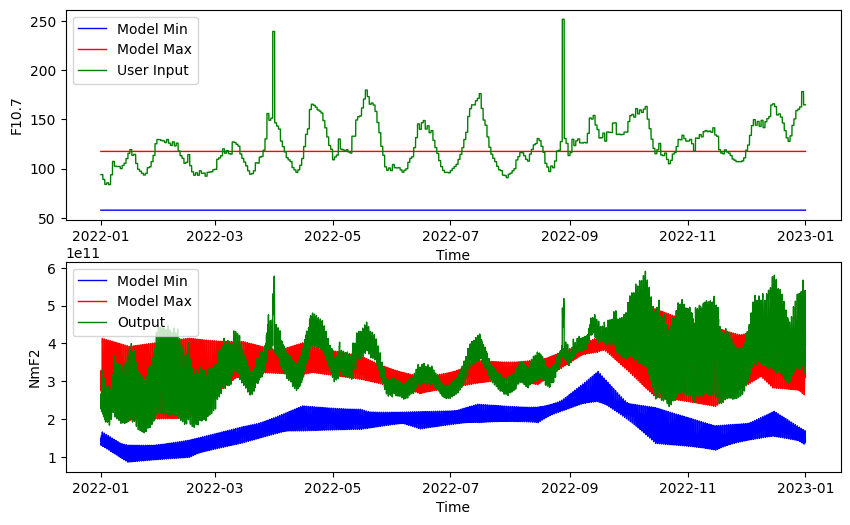

In [1]:
import numpy as np
import PyIRI
import PyIRI.main_library as ml
from datetime import datetime, timedelta
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

# Open your file with F10.7 index time series
solar_par = pd.read_pickle('/Users/vmakarevich/Documents/Science_VF2/Geomagnetic_Ind/GFZ_geo_solar_2000-2023.pkl')
F107 = solar_par['F107']
timearray = solar_par.index

# Checking if the user input of F10.7 has adequate numbers and excluding bad numbers
ind_bad = np.where((F107 < 50) | (F107 > 500))[0]
ind_good = np.where((F107 >= 50) & (F107 <= 500))[0]
if ind_bad.size > 0:
    time_cleaned = timearray[ind_good]
    F107_cleaned = F107[ind_good]
    F107[ind_bad] = np.interp(timearray[ind_bad], time_cleaned, F107_cleaned)

# Choose one year at a time
year = 2022 
a = np.where(solar_par.index.year == year)[0]
F107 = solar_par['F107'][a]
timearray = solar_par.index[a]

# Create an array of daily stamps
at_days = np.arange(datetime(year, 1, 1), datetime(year + 1, 1, 1), timedelta(days=1)).astype(datetime)
 
ccir_or_ursi = 0
 
#Create any horizontal grid (regular or irregular, global or regional). The grid arrays (alon and alat) should be flattened to be 1-D arrays. This is an example of a regular global grid:
lon_res = 30
lat_res = 30
alon_2d, alat_2d = np.mgrid[-180:180 + lon_res:lon_res, -90:90 + lat_res:lat_res]
alon = np.reshape(alon_2d, alon_2d.size)
alat = np.reshape(alat_2d, alat_2d.size)
aalt = np.array([250])
ahr = np.array(np.arange(0, 24, 0.25))
 
# Create empty dictionaries to store info for 12 months
NmF2 = np.empty((12, ahr.size, alon.size, 2), dtype=np.float64)
hmF2 = np.empty((12, ahr.size, alon.size, 2), dtype=np.float64)
 
#Run IRI for the middle of  each month
for imonth in range(0, 12):   
    month = imonth + 1     
    f2, f1, e_peak, es_peak, sun, mag = ml.IRI_monthly_mean_par(year, month, ahr, alon, alat, PyIRI.coeff_dir, ccir_or_ursi)
    NmF2[imonth, :, :, :] = f2['Nm'][:, :, :]
    hmF2[imonth, :, :, :] = f2['hm'][:, :, :]

# Create empty dictionaries to store each day of the year 
NmF2_days = np.zeros((at_days.size, ahr.size, alon.size, 2))
hmF2_days = np.zeros((at_days.size, ahr.size, alon.size, 2))
 
# Interpolate between months 
for i in tqdm(range(0, at_days.size)):
    t_before, t_after, fr1, fr2 = ml.day_of_the_month_corr(at_days[i].year, at_days[i].month, at_days[i].day)   
    NmF2_days[i, :, :, :] = NmF2[t_before.month - 1, :, :, :] * fr1 + NmF2[t_after.month - 1, :, :, :] * fr2
    hmF2_days[i, :, :, :] = hmF2[t_before.month - 1, :, :, :] * fr1 + hmF2[t_after.month - 1, :, :, :] * fr2

# Reshape to combine day and time into one dimension 
NmF2_days = np.reshape(NmF2_days, (at_days.size * ahr.size, alon.size, 2))
hmF2_days = np.reshape(hmF2_days, (at_days.size * ahr.size, alon.size, 2))
 
# Interpolate in solar index
F107_new = np.full((alon.size, F107.size), F107, order='F')
 
F_key = np.swapaxes(NmF2_days, 0, 2)
NmF2_solar = ml.solar_interpolate(F_key[0, :], F_key[1, :], F107_new)
NmF2_solar = np.swapaxes(NmF2_solar, 0, 1)
 
F_key = np.swapaxes(hmF2_days, 0, 2)
hmF2_solar = ml.solar_interpolate(F_key[0, :], F_key[1, :], F107_new)
hmF2_solar = np.swapaxes(hmF2_solar, 0, 1)

# Min and max from IG12 to F10.7
F107_min = ml.IG12_2_F107(0)
F107_max = ml.IG12_2_F107(100)

fig, ax = plt.subplots(2, 1)
fig.set_size_inches(10, 6)

ax_plot = ax[0]
ax_plot.set_xlabel('Time')
ax_plot.set_ylabel('F10.7')

t1 = 0
t2 = timearray.size
iloc = 90
ax_plot.plot(timearray[t1: t2], np.zeros((timearray[t1: t2].size)) + F107_min, linewidth=1, c='blue', label='Model Min')
ax_plot.plot(timearray[t1: t2], np.zeros((timearray[t1: t2].size)) + F107_max, linewidth=1, c='red', label='Model Max')
ax_plot.plot(timearray[t1: t2], F107[t1: t2], linewidth=1, c='green', label='User Input')
ax_plot.legend(loc='upper left', prop={'size': 10})

ax_plot = ax[1]
ax_plot.set_xlabel('Time')
ax_plot.set_ylabel('NmF2')
ax_plot.plot(timearray[t1: t2], NmF2_days[t1: t2, iloc, 0], linewidth=1, label='Model Min', c='blue')
ax_plot.plot(timearray[t1: t2], NmF2_days[t1: t2, iloc, 1], linewidth=1, label='Model Max', c='red')
ax_plot.plot(timearray[t1: t2], NmF2_solar[t1: t2, iloc], linewidth=1, label='Output', c='green')
ax_plot.legend(loc='upper left', prop={'size': 10})

 